# Import and Data

In [21]:
from genaibook.core import show_images
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from autoencoder import VariationalAutoEncoder, vae_loss, get_dataloader, train_model
import torchsummary
train_image_folder = '../../../dataset/3_class_train/'
val_image_folder = '../../../dataset/3_class_val/'
mean = np.array([0.6104, 0.5033, 0.4965])
std = np.array([0.2507, 0.2288, 0.2383])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_fraction_as_val = True
batch_size = 32
torch.manual_seed(1337)
from beta_vae import BetaVAE
model_name = 'VAE'

In [29]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomResizedCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    ),
}

if use_fraction_as_val:
    train_loader, val_loader = get_dataloader(image_folder=train_image_folder, 
                                                  transform=data_transforms['train'], 
                                                  batch_size=batch_size, shuffle=True, val_split=0.3)
    print(F"Using a fraction of {0.3} of the training data as validation data")
else:
    train_loader = get_dataloader(image_folder=train_image_folder,
                                  transform=data_transforms['train'], 
                                  batch_size=batch_size, shuffle=True)
    
    val_loader = get_dataloader(image_folder=val_image_folder,
                                transform=data_transforms['val'], 
                                batch_size=batch_size, shuffle=False)
    print(F"Using the data in {val_image_folder} as validation data")

Using a fraction of 0.3 of the training data as validation data


In [30]:
dataset_sizes = {"train": len(train_loader.dataset), "val": len(val_loader.dataset) if use_fraction_as_val else len(val_loader.dataset)}
print(f"DataSet Sizes: {dataset_sizes}")
print(f"Device: {device}")
print(f"Model Name: {model_name}")
print("Data Loaded")

DataSet Sizes: {'train': 3558, 'val': 1524}
Device: cuda:0
Model Name: VAE
Data Loaded


# Base VAE

In [4]:
latent_dims = 32
vae_model = VariationalAutoEncoder(in_channels=3, latent_dims=32).to(device)
torchsummary.summary(vae_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 112, 112]           6,272
       BatchNorm2d-2        [-1, 128, 112, 112]             256
              ReLU-3        [-1, 128, 112, 112]               0
            Conv2d-4          [-1, 256, 56, 56]         524,544
       BatchNorm2d-5          [-1, 256, 56, 56]             512
              ReLU-6          [-1, 256, 56, 56]               0
            Conv2d-7          [-1, 512, 28, 28]       2,097,664
       BatchNorm2d-8          [-1, 512, 28, 28]           1,024
              ReLU-9          [-1, 512, 28, 28]               0
           Conv2d-10         [-1, 1024, 14, 14]       8,389,632
      BatchNorm2d-11         [-1, 1024, 14, 14]           2,048
             ReLU-12         [-1, 1024, 14, 14]               0
           Linear-13                   [-1, 32]       6,422,560
           Linear-14                   

In [5]:
losses = train_model(vae_model, train_loader, val_loader, num_epochs=100, device=device)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Loss: 137221.8327
Validation Loss: 125642.7451
Validation Loss: 125592.4732
Validation Loss: 122934.8514
Validation Loss: 122302.7030
Validation Loss: 121613.8257
Validation Loss: 119639.8479
Validation Loss: 119244.2820
Validation Loss: 117245.3568
Validation Loss: 115959.2181
Validation Loss: 118916.3450
Validation Loss: 116640.6084
Validation Loss: 116727.8344
Validation Loss: 116831.0298
Validation Loss: 116703.4684
Validation Loss: 117158.2078
Validation Loss: 117985.9467
Validation Loss: 117754.3040
Validation Loss: 116238.2267
Validation Loss: 118440.7760
Validation Loss: 117878.9462
Validation Loss: 116326.0295
Validation Loss: 119818.7363
Validation Loss: 118045.1456
Validation Loss: 116109.2158
Validation Loss: 120011.9093
Validation Loss: 117477.0056
Validation Loss: 117409.6050
Validation Loss: 116601.8852
Validation Loss: 116152.1624
Validation Loss: 117709.3588
Validation Loss: 116968.8306
Validation Loss: 118706.3917
Validation Loss: 118054.0904
Validation Los

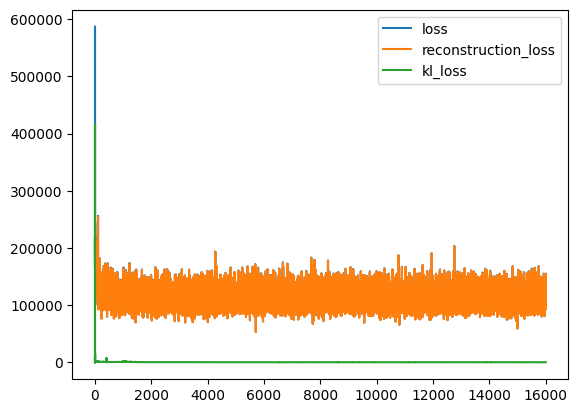

In [6]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

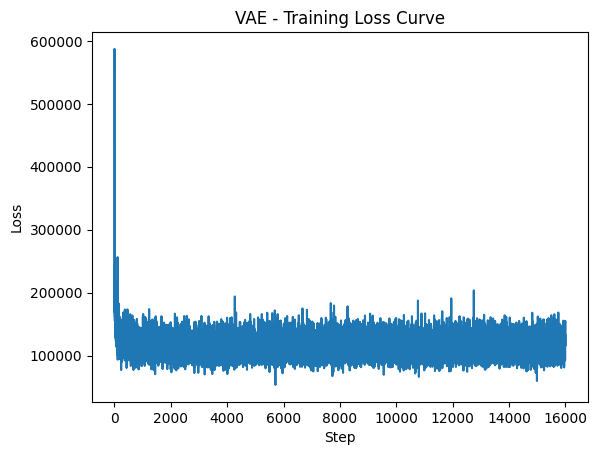

In [7]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE - Training Loss Curve")
plt.show()

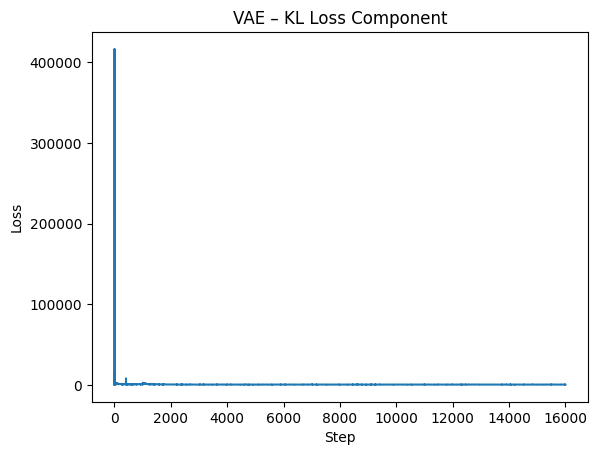

In [8]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – KL Loss Component")
plt.show()

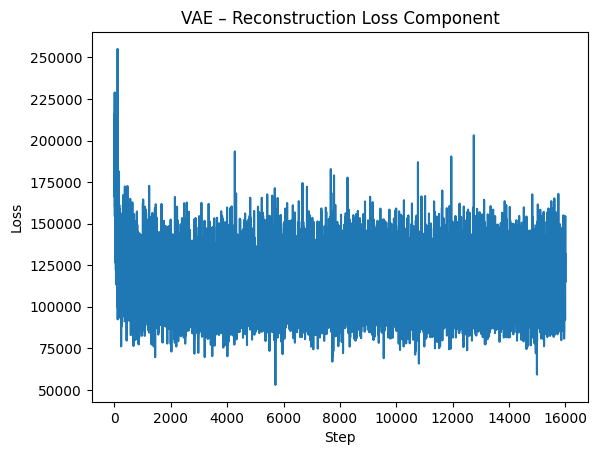

In [9]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – Reconstruction Loss Component")
plt.show()

In [10]:
test_loader = get_dataloader(image_folder=val_image_folder,
                                transform=data_transforms['val'], 
                                batch_size=8, shuffle=False)

In [11]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(test_loader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4347827..1.4338835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0593634..0.9025521].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7541051..1.5369078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4347827..1.9318622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3252854..1.5204513].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0138397..0.9280197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.017096

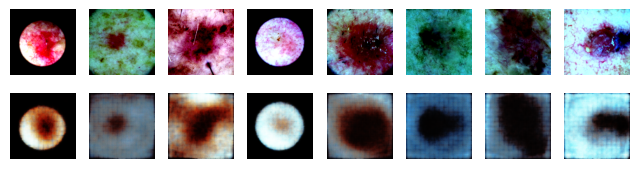

In [12]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

In [16]:
# load the best model
vae_model.load_state_dict(torch.load('vae_model_best.pth'))
vae_model.eval()

/tmp/ipykernel_180540/355747162.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model_best.pth'))


VariationalAutoEncoder(
  (encoder): VAEEncoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (mu): 

In [17]:
z = torch.normal(0, 1, size=(10, 32))
vae_decoded = vae_model.decode(z.to(device))

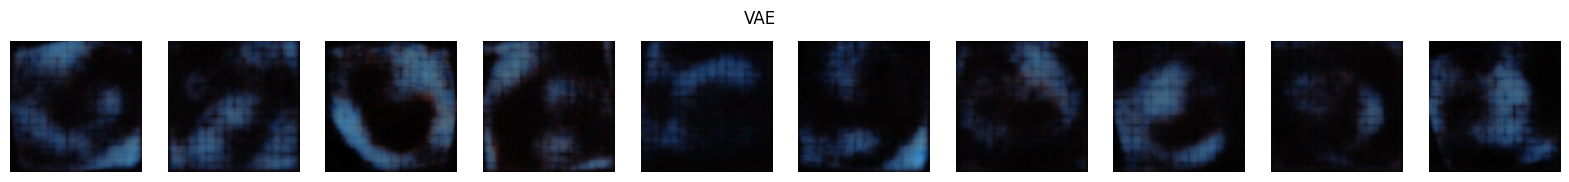

In [19]:
show_images(vae_decoded.cpu(), imsize=2, nrows=1, suptitle="VAE")

# Beta VAE

In [31]:
beta_vae_model = BetaVAE(in_channels=3, latent_dim=128, beta=4).to(device)
torchsummary.summary(beta_vae_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         LeakyReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
      BatchNorm2d-11            [-1, 256, 4, 4]             512
        LeakyReLU-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 2, 2]       1,180,160
      BatchNorm2d-14            [-1, 51

In [32]:
losses = train_model(beta_vae_model, train_loader, val_loader, num_epochs=100, device=device)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

In [ ]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Beta VAE - Training Loss Curve")
plt.show()

In [ ]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Beta VAE – KL Loss Component")
plt.show()

In [ ]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Beta VAE – Reconstruction Loss Component")
plt.show()

In [ ]:
test_loader = get_dataloader(image_folder=val_image_folder,
                                transform=data_transforms['val'], 
                                batch_size=8, shuffle=False)

In [ ]:
beta_vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(test_loader))
    predicted, mu, logvar = (v.cpu() for v in beta_vae_model(eval_batch.to(device)))

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)